In [1]:
use_gdrive = False
gdrive_path = "XAI"

force_rebuild = True

## Helpers

### Imports

In [2]:
import dill
import matplotlib.pyplot as plt
from datetime import datetime
import math
import spacy
import sys
import time

try:
    from sty import fg, bg, ef, rs, Style, RgbBg
except:
    # "sty" package is not installed
    !pip install sty
    from sty import fg, bg, ef, rs, Style, RgbBg


### Train-Eval-Acc Functions

In [3]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch
    ie. if you get 8/10 right => 0.8
    """

    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [4]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text.to(device)).squeeze(1)

        loss = criterion(predictions, batch.label.to(device))
        acc = binary_accuracy(predictions, batch.label.to(device))
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [5]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:      
            predictions = model(batch.text).squeeze(1)


            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### General Utils

In [6]:
""" Colab gdrive utils """
from google.colab import drive
from pathlib import Path
import os

def mount_drive():
    if use_gdrive:
        drive.mount('/content/drive')
        os.chdir('/content/drive/My Drive')




        #Set working dir as given gdrive root
        os.chdir('/content/drive/My Drive/'+gdrive_path)
        print(f'Working directory set to: \"{os.getcwd()}\"')

def unmount_drive():
    if use_gdrive:
        drive.flush_and_unmount()
        os.chdir('/content')

mount_drive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory set to: "/content/drive/My Drive/XAI"


In [7]:
""" Timer utils"""
from math import floor

# Tic and Toc as callable functions
ticTime = {}


def tic(timer_name=""):
    global ticTime
    ticTime[timer_name] = time.time()


def toc(timer_name="", milisecond=False):
    global ticTime
    if ticTime.get(timer_name) is not None:
        printTime(time.time() - ticTime[timer_name], timer_name, milisecond)
    else:
        print(f'No running timer with name: \"{timer_name}\" found !!!')

# Direct call to functions with arguments for timing


def timeIt(func, *args):
    tic()
    func(*args)
    toc()


# Helper function to format and print Time Info to console
def printTime(time, timer_name=None, milisecond=False):
    prefix, suffix = f'Time passed {timer_name}:', ' '
    first = True

    if(time > 1500000000):
        print("!!! Please use tic() first !!!")
        return

    if (floor(time / 3600) > 0):
        hours = floor(time / 3600)
        suffix += str(hours) + " Hour"
        time -= hours * 3600
        first = False
    if (floor(time / 60) > 0):
        minutes = floor(time / 60)
        if (not first):
            suffix += " / "
        suffix += str(minutes) + " Min"
        time -= minutes * 60
        first = False
    if (time > 0):
        seconds = floor(time)
        if (not first):
            suffix += " / "
        suffix += str(seconds) + " Sec"
        time -= seconds
        first = False
    if (milisecond):
        if (not first):
            suffix += " / "
        suffix += str(floor(time*1000)) + " Milisec"

    print(prefix, suffix)


def test(x, y):
    for i in range(1, 5100):
        a = 12345 / i
        a += 1
    print(x, y)


In [8]:
# Create model save folder
def get_model_save_folder():
    model_run_date = datetime.now().strftime("%d.%m.%Y  %H:%M:%S")
    if not os.path.exists(f'runs/{model_run_date}'):
        os.makedirs(f'runs/{model_run_date}')
    return base_dir + f'/runs/{model_run_date}/'

def save_model(save_dir, model, epoch, valid_loss, valid_acc, model_name=None):
    os.chdir(save_dir)
    model_name = 'model_final' if model_name is None else model_name
    torch.save(model.state_dict(),
               f'{model_name}.pt')
      
    os.chdir(base_dir)

### Testing Utils

In [9]:
def get_example(iterator, index=0, max_len=99999999):
    """
    iterator: data iterator
    index: index of batch inside iterator
    max_len: max number of words for text
    """
    with torch.no_grad():
        for batch in iterator:
            example_text = batch.dataset[index].text
            example_label = batch.dataset[index].label
    return example_text[:max_len], example_label

In [10]:
def count_parameters(model):
    """
    Returns number of parameters in the model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
nlp = spacy.load('en')

def predict_sentiment(model, sentence, min_len = 5):
    """
    Model word predictor 
    """
    sentence = sentence.replace('_',' ')
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    tokenized = ['<pad>'] + ['<pad>'] + tokenized + ['<pad>'] + ['<pad>']
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    
    return prediction.item()

def predict_sentiment_with_text(model, sentence):
    return f'{predict_sentiment(model, sentence):.5f} | {sentence}'

### Analysis functions

In [12]:
def normalize_dict_scores(dictionary, range_start=0, range_end=100, override_start = None , override_end = None):
    dic_min  = np.min(list(dictionary.values())) if override_start is None else override_start
    dic_max  = np.max(list(dictionary.values())) if override_end   is None else override_end
    dic_diff = dic_max - dic_min

    dictionary = dict(map(lambda item: (item[0], (item[1] * ((range_end - range_start) / dic_diff))), dictionary.items()))

    return dictionary

In [13]:
def token_dict_to_colored_string(review, tokens_dict):
    review_tokens = review.split(" ")
    out=""
    for token in review_tokens:
        if token != '':
            color_code = int(tokens_dict[token])
            if color_code >= 0:
                bg.gradient = Style(RgbBg(color_code, 10, 10))
            else:
                bg.gradient = Style(RgbBg(10, 10, -color_code))

            out+=f'{bg.gradient} {token} {bg.rs}'
    return out

In [14]:
def get_array_element(array, index):
    if index < 0:
        return ""
    elif index >= len(array):
        return ""
    else:
        return array[index]+ " "

def predict_word_scores(model, review, window_length, normalize_to_pixel=True):
    model.eval()
    tokens = review.split(" ")
    tokens_dict={}
    tokens_occurance_dict={}
    for token in tokens:
        if token != '':
          tokens_dict[token] = 0
          tokens_occurance_dict[token] = 0

    for i in range(1 - window_length , len(tokens)):
        # print(f'Index: {i}')

        # Get analysis text slice
        analysis_text = []
        for j in range(i,i+window_length):
            # print(f'{j} / ', end="") if j < (i+window_length-1) else print(j)
            analysis_text.append(get_array_element(tokens,j))

        # Get Text prediction scores
        analysis_text = ''.join(map(str, analysis_text))[:-1]
        analysis_pred = (predict_sentiment(model, analysis_text)-0.5)*2
                
        # Add predictions to dictinary
        for j in range(i,i+window_length):
            element = get_array_element(tokens,j)[:-1]
            if element != '':
                tokens_dict[element] = tokens_dict[element] + analysis_pred
                tokens_occurance_dict[element] += 1

    # Divide token occurance by window_length 
    # tokens_occurance_dict = dict(map(lambda item: (item[0], (item[1] / window_length)), tokens_occurance_dict.items()))

    # Divide total token scores by element occurance
    tokens_dict = dict(map(lambda item: (item[0], (item[1] / tokens_occurance_dict[item[0]])), tokens_dict.items()))


    # print(f'"{analysis_text}" => {analysis_pred}')
    # print(f'                Raw {tokens_dict}')
    if normalize_to_pixel:
        tokens_dict_norm = normalize_dict_scores(tokens_dict,
                                                 range_start=-256,
                                                 range_end=256,
                                                 override_start = -1,
                                                 override_end = 1)
    else:
        tokens_dict_norm = normalize_dict_scores(tokens_dict,
                                                 range_start=-100,
                                                 range_end=100,
                                                 override_start = -1,
                                                 override_end = 1)
    # print(f'Norm (-256 <-> 256) {tokens_dict_norm}')
    # print()
    model.train()
    return tokens_dict_norm

### UI Elements & User feedback

In [15]:
import ipywidgets
from ipywidgets import Button, Layout, ButtonStyle, HBox, VBox, Label
from string import ascii_lowercase
from IPython.display import display

# Choice Button for displaying words
class ChoiceButton(Button):
    """
    state = 0 => No Selection
    state = 1 => Positive Update
    state = 2 => Negative Update
    """
    button_type = None
    state = 0
    
    def __init__(self, button_type, **kwargs): 
        self.button_type = button_type
        super().__init__(**kwargs)
    
    def toggle(self):
        if self.state == 0:
            if self.button_type is "Positive":
                self.state = 2
                self.style.button_color = 'Blue'
            else:
                self.state = 1
                self.style.button_color = 'FireBrick'
        else:
            self.state = 0
            self.style.button_color = 'GhostWhite'


# Finalize button for ending word selection
class FinalizeButton(Button):
    max_window_length = 5
    words_dict = {}

    def finalize(self):    
        self.words_dict = {}
        for hbx in ui_elements:
            if isinstance(hbx, HBox):
              for bx in hbx.children:
                  if bx.state != 0:
                    dic_key = f'<pad> <pad> {bx.description} <pad> <pad>'
                    self.words_dict[dic_key] = bx.state



In [16]:
ui_elements = []

def interact_w_user(words):
    # Add Boxed Buttons
    ui_elements.clear()
    box = []

    # Add Word Buttons
    for i in range(len(words)):
        # Add Positive Label
        if i == 0:
            ui_elements.append(Label(value="Highest POSITIVE words",layout=Layout(width='395px', height='30px')))
        # Add Positive word buttons
        if i < num_positive_words:
            btn = ChoiceButton(button_type="Positive",
                               description=words[i].replace('_',' '), 
                               layout=Layout(width='200px', height='30px'),
                               style=ButtonStyle(button_color='GhostWhite'))
            btn.on_click(ChoiceButton.toggle)
            box.append(btn)

        # Add Negative Label
        if i == len(words)/2:
            ui_elements.append(Label(value="Highest NEGATIVE words",layout=Layout(width='395px', height='30px')))
        # Add Negative word buttons
        if i >= num_positive_words:
            btn = ChoiceButton(button_type="Negative",
                               description=words[i].replace('_',' '), 
                               layout=Layout(width='200px', height='30px'),
                               style=ButtonStyle(button_color='GhostWhite'))
            btn.on_click(ChoiceButton.toggle)
            box.append(btn)
        if i%5 == 4:
            ui_elements.append(HBox(box))
            box = []

    # Add Finalize Button
    btn_finalize = FinalizeButton(description='!   Finalize Selection   !', 
                                  layout=Layout(width='293px', height='50px'),
                                  style=ButtonStyle(button_color='Aquamarine'))
    btn_finalize.on_click(FinalizeButton.finalize)
    ui_elements.append(Label(value="Click Finalize when you are done selecting",
                      layout=Layout(width='395px', height='30px')))
    ui_elements.append(btn_finalize)
    button_box = VBox(ui_elements)

    display(button_box)

def get_selected_words_dict():
    last_ui_elem = len(ui_elements) - 1
    return ui_elements[last_ui_elem].words_dict



In [17]:
import csv

def create_training_data(out):
    """
    Returns data_iterator from given sequence of words 
    @Return: <torchtext.data.iterator.BucketIterator>
    """
    #x = input("ready?")
    # feedbacks = [{"text":k, "label":v} for k, v in out.items() if v == 0 or v == 1]
    feedbacks = [{"text":k, "label":"pos"} for k, v in out.items() if v == 1]
    feedbacks1 = [{"text":k, "label":"neg"} for k, v in out.items() if v == 2]
    feedbacks += feedbacks1
    keys = ["text","label"]
    # print(feedbacks)
    # Check if root dir exist
    if use_gdrive:
        Path('tempDataset').mkdir(parents=True, exist_ok=True)
        with open("tempDataset/TSVFile.tsv", 'w') as output_file:
            dict_writer = csv.DictWriter(output_file, keys, delimiter='\t')
            dict_writer.writeheader()
            dict_writer.writerows(feedbacks)  
        fields = [('text', TEXT), ('label', LABEL)]
        updated_train_data = data.TabularDataset(path = 'tempDataset/TSVFile.tsv',
                                                format = 'tsv',
                                                fields = fields,
                                                skip_header = True) 
    else: 
        with open("/tempDataset/TSVFile.tsv", 'w') as output_file:
            dict_writer = csv.DictWriter(output_file, keys, delimiter='\t')
            dict_writer.writeheader()
            dict_writer.writerows(feedbacks)  
        fields = [('text', TEXT), ('label', LABEL)]
        updated_train_data = data.TabularDataset(path = '/tempDataset/TSVFile.tsv',
                                                format = 'tsv',
                                                fields = fields,
                                                skip_header = True) 
    BATCH_SIZE = 1
    # print(f'Updated train data len:{len(updated_train_data)}')
    # print(updated_train_data.examples[0].text)
    # print(updated_train_data.examples[0].label)
    # print(updated_train_data.fields)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # print(len(TEXT.vocab))
    updated_train_iterator = data.BucketIterator(
                updated_train_data,
                sort_key=lambda x: len(x.text),
                batch_size = BATCH_SIZE)
    # print(len(updated_train_iterator))
    return updated_train_iterator

### Kernel Visualization

In [18]:
def get_conv_tensor(model_parameters, conv_filter=0):
    for param in model_parameters:
        if len(param.shape) == 1: # Skip bias layer
            continue
        # print(param.shape)
        np_arr = param[conv_filter].cpu().detach().numpy()
        return np_arr

def normalize_array_to_pixel_range(np_arr, range_start=None, range_end=None, debug=False):
    armin = np.min(np_arr) if range_start is None else range_start
    armax = np.max(np_arr) if range_end is None else range_end
    diff = armax - armin
    if diff == 0:
        diff = 1e-30  # Use very small diff if its 0 for preventing division by 0
    if debug:
        print(f'  orig: min:{armin} max:{armax} diff:{diff}')

    scaled = np_arr.copy()
    scaled *= (255/diff)
    scaled -= np.min(scaled)
    scmin = np.min(scaled)
    scmax = np.max(scaled)
    diff = scmax-scmin
    if debug:
        print(f'scaled: min:{scmin} max:{scmax} diff:{diff}')
    return scaled

### Mounting Google drive

In [19]:
if use_gdrive:
    mount_drive()

base_dir = os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory set to: "/content/drive/My Drive/XAI"


## Preparing Data

In [20]:
#@markdown Should a `fixed seed` used for weight initialization and other random events
use_fixed_seed = True #@param {type:"boolean"}




### Processing

In [21]:
def preprocess_sentences(texts):
    preprocessed = []
    for w in texts:
        w = w.lower().strip()
        w = re.sub(r'n\'t', " not", w)
        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        w = re.sub(r"([?.!,])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)

        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-z]+", " ", w)
        
        # removing single word chars from sentence
        w =  re.sub(r"\b[a-z]\b", "", w)
        #removing multiple spaces
        w =  re.sub(r" +", " ", w)
        # removing new lines
        w =  re.sub(r"\n", "", w)
        w = w.strip()
        if w!="":
            preprocessed.append(w)
    return preprocessed

In [22]:
import torch
from torchtext import data
from torchtext import datasets
import random
import numpy as np
import re

SEED = 1234

## Setting torch random seed
if use_fixed_seed:
    # For CPU
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    # For GPU
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

# torch.backends.cudnn.deterministic = True
tokenizer = lambda s: s.split()

# TEXT = data.Field(preprocessing=preprocess_sentences, tokenize = 'spacy', batch_first = True)
TEXT = data.Field(preprocessing=preprocess_sentences, tokenize = tokenizer, batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

In [23]:
fields = [('label', LABEL),('text', TEXT)]

### Splitting into train / valid / test  

This will take some time.. Usually ~2 minutes on Google Colab

In [24]:
unmount_drive()
tic("process")
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
toc("process")

train_data, valid_data = train_data.split(random_state = random.seed(SEED))
mount_drive()

Time passed process:  1 Min / 36 Sec
Mounted at /content/drive
Working directory set to: "/content/drive/My Drive/XAI"


In [25]:
save_data = False

if save_data:
    torch.save(train_data.examples, "model/train_examples.pkl", pickle_module=dill)
    torch.save(train_data.fields , "model/train_fields.pkl", pickle_module=dill)
    torch.save(valid_data.examples, "model/valid_examples.pkl", pickle_module=dill)
    torch.save(valid_data.fields , "model/valid_fields.pkl", pickle_module=dill)
    torch.save(test_data.examples, "model/test_examples.pkl", pickle_module=dill)
    torch.save(test_data.fields , "model/test_fields.pkl", pickle_module=dill)

In [26]:
from torchtext.data import Dataset
# examples = torch.load("model/train_examples.pkl", pickle_module=dill)
# fields = torch.load("model/train_fields.pkl", pickle_module=dill)
# tt = Dataset(examples, fields)

In [27]:
load_data = False

if load_data:
    from torchtext.data import Dataset

    examples = torch.load("model/train_examples.pkl", pickle_module=dill)
    fields = torch.load("model/train_fields.pkl", pickle_module=dill)
    train_data = Dataset(examples, fields)

    examples = torch.load("model/valid_examples.pkl", pickle_module=dill)
    fields = torch.load("model/valid_fields.pkl", pickle_module=dill)
    valid_data = Dataset(examples, fields)

    examples = torch.load("model/valid_examples.pkl", pickle_module=dill)
    fields = torch.load("model/valid_fields.pkl", pickle_module=dill)
    test_data = Dataset(examples, fields)

In [28]:
print(f'Train Set Size: {len(train_data.examples)}')
print(f'Valid Set Size: {len(valid_data.examples)}')

Train Set Size: 17500
Valid Set Size: 7500


Build the vocab and load the pre-trained word embeddings.

In [29]:
if force_rebuild:
    MAX_VOCAB_SIZE = 25_000

    TEXT.build_vocab(train_data, 
                    max_size = MAX_VOCAB_SIZE, 
                    vectors = "glove.6B.200d", 
                    unk_init = torch.Tensor.normal_)

    LABEL.build_vocab(train_data)

    # Save
    Path('model').mkdir(parents=True, exist_ok=True)
    with open("model/TEXT.Field","wb")as f:
        dill.dump(TEXT,f)
    with open("model/LABEL.Field","wb")as f:
        dill.dump(LABEL,f)


In [30]:
load_field=False

if load_field:
    import dill
    with open("model/TEXT.Field","rb")as f:
        TEXT=dill.load(f)
    with open("model/LABEL.Field","rb")as f:
        LABEL=dill.load(f)

    print(LABEL)

In [31]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Creating Iterators
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [32]:
train_data[5].text
len(TEXT.vocab)

25002

In [33]:
for batch in train_iterator:
  print(batch)
  print(batch.text)
  print(len(batch.text[4]))
  print(batch.text[0][0])
  break


[torchtext.data.batch.Batch of size 64]
	[.text]:[torch.cuda.LongTensor of size 64x724 (GPU 0)]
	[.label]:[torch.cuda.FloatTensor of size 64 (GPU 0)]
tensor([[ 737,   33, 7486,  ...,    1,    1,    1],
        [ 765,   30, 2285,  ...,    1,    1,    1],
        [ 363,  142,    2,  ...,    1,    1,    1],
        ...,
        [  52,  860,  803,  ...,    1,    1,    1],
        [  20, 4055,   41,  ...,    1,    1,    1],
        [  13,    0,    3,  ...,    1,    1,    1]], device='cuda:0')
724
tensor(737, device='cuda:0')


## Model

In [34]:
#@markdown ---
GloVe_Embedding_Dim  = '200' #@param ['50', '100', '200', '300']  {type:"string"}
GloVe_Embedding_Dim = int(GloVe_Embedding_Dim)
Dropout = 0.55#@param {type: "number", min: 0, max: 1}


#@markdown \
#@markdown 
#@markdown ---
#@markdown ### CNN Layer Hyperparameters
#@markdown How many features will be extracted by each CNN Kernel.
#@markdown So this is the *3x1x`N`* value for CNN Layer
Num_of_extracted_features = 100#@param {type: "integer"}
Num_of_extracted_features = int(Num_of_extracted_features)
#@markdown ex. for 3-gram + 4-gram + 5-gram => n_gram: 3,4,5   
N_gram = "3,4,5" #@param {type:"string"}
N_gram = list(map(int, N_gram.split(',')))


### CNN 1D + Mask

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class CNN1dmod(nn.Module):
  
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        super().__init__()
        # GloVe Embedding      
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        # Masking Layer
        self.mask= nn.Parameter(torch.ones(embedding_dim))
        self.maskcnn= nn.Parameter(torch.ones(3,100))

        # Conv Layer ( 3-gram / 4-gram / 5-gram ... )
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes])
        
        # Fully Connected Layers       
        self.fc1 = nn.Linear(len(filter_sizes) * n_filters, 300)
        self.fc2 = nn.Linear(300,150)
        self.fc3 = nn.Linear(150,output_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
      
        # Word -> Embedding    
        embedded = self.embedding(text)
        # print(embedded1.shape)

        # print(embedded.shape)
        # Embedding -> Masked Embedding
        embedded = embedded * self.mask.repeat(embedded.shape[0],
                                               embedded.shape[1],
                                               1)  
        embedded = embedded.permute(0, 2, 1)

        # Masked Embedding -> 3-gram / 4-gram / 5-gram conv layers
        conved = []                                       # Uncomment this BLOCK FROM HERE mask layer added version
        for i in range(len(self.convs)):
            x = F.relu(self.convs[i](embedded))
            #   print(x.shape[0],x.shape[1],x.shape[2])
            x = x.permute(0, 2, 1) 
            x = x * self.maskcnn[i].repeat(x.shape[0],
                                      x.shape[1],
                                      1)     
            x = x.permute(0, 2, 1)
            conved.append(x)                              # Uncomment this BLOCK TO HERE mask layer added version
        # conved = [F.relu(conv(embedded)) for conv in self.convs]      # Uncomment this for no mask layer version

        # Max Pooling CONV layers    
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]        
        # pooled_n = [batch size, n_filters]  
        
        # Concat Conv Outputs -> FullConnected Layers  
        # x = self.dropout(torch.cat(pooled, dim = 1)) * self.mask1   # Uncomment this for mask layer added version
        x = self.dropout(torch.cat(pooled, dim = 1))
        
        # x = self.dropout(F.relu(self.fc1(x) * self.mask2) )     # Uncomment this for mask layer added version
        # x = self.dropout(F.relu(self.fc2(x) * self.mask3) )     # Uncomment this for mask layer added version
        x = self.dropout(F.relu(self.fc1(x) ))            # Uncomment this for no mask layer version
        x = self.dropout(F.relu(self.fc2(x) ))            # Uncomment this for no mask layer version
        
        
        return self.fc3(x)

    def set_train_mode_mask(self):
        """
        Sets the network into "Mask Layer Training Only" mode
          * Doesnt train Embeddings
          * Trains Mask Layer
          * Doesnt train any other Layers 
        """
        for name, param in self.named_parameters():
            if 'mask' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
    
    def set_train_mode_base(self):
        """
        Sets the network into "Base Model Training" mode
          * Doesnt train Embeddings
          * Doesnt train Mask Layer
          * Trains all other Layers 
        """
        for name, param in self.named_parameters():
            if 'mask' in name or 'embedding' in name:
                param.requires_grad = False
            else:
                param.requires_grad = True


Getting "\<unk\>" and "\<pad\>" token ID's

In [36]:
unk_token_id = TEXT.vocab.stoi[TEXT.unk_token]
pad_token_id = TEXT.vocab.stoi[TEXT.pad_token]

### Building Model

In [37]:
input_dimension = len(TEXT.vocab)
output_dimension = 1

model = CNN1dmod(input_dimension, 
                 GloVe_Embedding_Dim,
                 Num_of_extracted_features,            
                 N_gram, 
                 output_dimension,
                 Dropout, 
                 pad_token_id)

model.set_train_mode_base()
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 375,901 trainable parameters


Loading pre-trained embeddings

Note: +2 is from "\<unk\>" and "\<pad\>" tokens

In [38]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

# print(model.embedding.weight.data)
model.embedding.weight.data.copy_(pretrained_embeddings)
# print(model.embedding.weight.data)

# Make initial embeddings of "<unk>" and "<pad>" as zero
model.embedding.weight.data[unk_token_id] = torch.zeros(GloVe_Embedding_Dim)
model.embedding.weight.data[pad_token_id] = torch.zeros(GloVe_Embedding_Dim)

torch.Size([25002, 200])


## Train the Model

In [39]:
save_dir = get_model_save_folder()

In [40]:
NUM_BASE_TRAIN_EPOCHS = 21 #21
NUM_MASK_TRAIN_EPOCHS = 101 #101

In [41]:
import torch.optim as optim

model.set_train_mode_base()
# Optimizers for saperate trainings
optimizer_network = optim.Adam(
    filter(lambda p: (p.requires_grad)==True,  model.parameters()), lr=0.0004, weight_decay=0.005)
optimizer_mask = optim.Adam(
      model.parameters(), lr=0.0000005, weight_decay=0.2)


criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

### Base Model Training

In [42]:
# Visualization for Base model training (Accuracy / Loss)
from IPython.display import clear_output
def visualize_base_training(epoch, best_epoch):
    clear_output(wait=True)
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    plt.plot(train_acc_all, label='Train')
    plt.plot(valid_acc_all, label='Valid', color="orange", linestyle ='-')
    plt.plot(valid_acc_all[:best_epoch+1], label='Base Model', color="orange", linewidth=6.0 )
    plt.plot(best_epoch, valid_acc_all[best_epoch], color='orange', markersize=7, marker="D")
    plt.title('Accuracy over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(0.60,1)
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(train_loss_all, label='Train', color='tab:blue')
    plt.plot(valid_loss_all, label='Valid', color="orange", linestyle ='-')
    plt.plot(valid_loss_all[:best_epoch+1], label='Base Model', color="orange", linewidth=6.0 )
    plt.plot(best_epoch, valid_loss_all[best_epoch], color='orange', markersize=7, marker="D")
    plt.title('Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim(0.2,1)
    plt.savefig(f'train_base_{epoch}')
    plt.show()

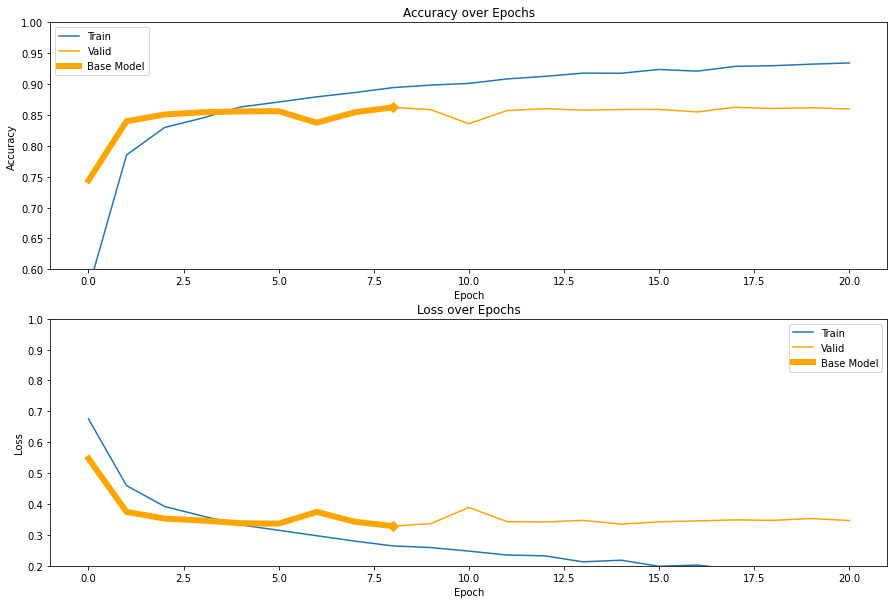

Network Epoch: 21 | Time: 10s
                  | Train Loss: 0.178 | Train Acc: 93.40%
                  | Valid Loss: 0.346 | Valid Acc: 85.95%


In [43]:
examples_base = []

train_acc_all = []
train_loss_all = []
valid_acc_all = []
valid_loss_all = []

best_valid_loss = float('inf')
best_epoch = 0

model.set_train_mode_base()
for epoch in range(NUM_BASE_TRAIN_EPOCHS):
    start_time = time.time()
    
    # Train Model
    train_loss, train_acc = train(model, train_iterator, optimizer_network, criterion)
    
    # Evaluate on "validation" data
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.time()
    epoch_secs = int(end_time - start_time)
    
    # example_text, example_label = get_example(train_iterator)
    # example_text = ' '.join([str(elem) for elem in example_text])
    example_text = 'normally the first minutes of the film annoy me it includes some reference to the incredible melting man'
    example_predictions = predict_word_scores(model, example_text, window_length=1)
    example_colored_text = token_dict_to_colored_string(example_text, example_predictions)
    examples_base.append(example_colored_text)

    if valid_loss < best_valid_loss:
        save_model(save_dir, model, epoch, valid_loss, valid_acc, model_name='model_base_final')
        best_epoch = epoch
        best_valid_loss = valid_loss
 
    # Save scores and visualize training
    train_acc_all.append(train_acc)
    train_loss_all.append(train_loss)
    valid_acc_all.append(valid_acc)
    valid_loss_all.append(valid_loss)
    visualize_base_training(epoch, best_epoch)

    
    print(f'Network Epoch: {epoch+1:02} | Time: {epoch_secs}s')
    print(f'                  | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'                  | Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

##########################################################################################################################

Sanity check to see if we are keeping the "best" or "last" model from previous training

In [44]:
model.load_state_dict(torch.load( save_dir + 'model_base_final.pt' ))

valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

print(f'Sanity check for best "base model"')
print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

Sanity check for best "base model"
Valid Loss: 0.329 | Valid Acc: 86.22%


In [45]:
# Visualize sentence explanations over epochs
for i in range(len(examples_base)):
  print(f'Epoch {i:<2}: {examples_base[i]}')

Epoch 0 :  normally  the  first  minutes  of  the  film  annoy  me  it  includes  some  reference  to  the  incredible  melting  man 
Epoch 1 :  normally  the  first  minutes  of  the  film  annoy  me  it  includes  some  reference  to  the  incredible  melting  man 
Epoch 2 :  normally  the  first  minutes  of  the  film  annoy  me  it  includes  some  reference  to  the  incredible  melting  man 
Epoch 3 :  normally  the  first  minutes  of  the  film  annoy  me  it  includes  some  reference  to  the  incredible  melting  man 
Epoch 4 :  normally  the  first  minutes  of  the  film  annoy  me  it  includes  some  reference  to  the  incredible  melting  man 
Epoch 5 :  normally  the  first  minutes  of  the  film  annoy  me  it  includes  some  reference  to  the  incredible  melting  man 
Epoch 6 :  normally  the  first  minutes  of  the  film  annoy  me  it  includes  some  reference  to  the  incredible  melting  man 
Epoch 7 :  normally  the  first  minutes  of  the  film  annoy

In [46]:
!ffmpeg -r 3 -f image2 -s 1920x1080 -i train_base_%01d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p -y train_base.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Lets generate some examples to visualize how the network sees words

In [47]:
examples = []

for i in range(20):
    example_text, example_label = get_example(train_iterator, index=i)
    text = ' '.join([str(elem) for elem in example_text]) 
    tokens_dict_1 = predict_word_scores(model, text, window_length=1)
    pos_words = []
    neg_words = []
    for w in sorted(tokens_dict_1, key=tokens_dict_1.get, reverse=True):
        if len(pos_words)==5 or tokens_dict_1[w]<0:
            break
        pos_words.append(w)
    for w in sorted(tokens_dict_1, key=tokens_dict_1.get, reverse=False):
        if len(neg_words)==5 or tokens_dict_1[w]>0:
            break
        neg_words.append(w)

    words =pos_words + neg_words
    # print("positive examples : ", pos_words)
    # print("negative examples : ", neg_words)
    colored_text = token_dict_to_colored_string(text, tokens_dict_1)
    examples.append((colored_text,pos_words,neg_words))
    print(colored_text)

 need  lesson  in  pure  abject  failure  look  no  further  than  wizards  of  the  lost  kingdom  an  abysmal  dirt  poor  disgrace  of  flick  as  we  all  know  decent  moovies  tend  to  sprout  horrible  horrible  offspring  halloween  begat  many  many  bad  slasher  flicks  mad  max  begat  many  many  bad  futuristic  wasteland  fantasy  flicks  and  conan  the  barbarian  begat  whole  slew  of  terrible  horrible  incredibly  bad  sword  and  sorcery  flicks  wizards  of  the  lost  kingdom  scrapes  the  bottom  of  that  barrel  in  way  that  truly  insulting  to  barrels  young  runt  named  simon  recaptured  his  good  kingdom  from  an  evil  sorcerer  with  the  help  of  mangy  rug  garden  gnome  topless  bimbo  mermaid  and  tired  looking  pudgy  bo  svenson  svenson  north  dallas  forty  inglorious  bastards  delta  force  long  time  moovie  muscleman  looks  barely  able  to  swing  his  aluminum  foil  sword  however  he  manages  to  defeat  the  forces  of

### User Feedback

In [48]:
num_positive_words = 80#@param {type: "integer"}
num_negative_words = 80#@param {type: "integer"}
#@markdown If not selected, user wont be asked for feedback and a preselected set will be used.
ask_user_feedback = False #@param {type:"boolean"}

Get all unique word pairs occure more than `min_occurence` times from training iterator

In [49]:
def get_windowed_predictions(model, window_length, min_occurence=1):
    dic = {}
    with torch.no_grad():
        for batch in train_iterator:
            for index in range(0, len(batch.dataset)):
                example_text = batch.dataset[index].text
                # print(index, len(dic.keys()))
                for i in range(0,len(example_text)-window_length+1):
                    elem = ""
                    for winlen in range(window_length):
                        elem += example_text[i+winlen] + ' '
                    elem = elem[:-1]

                    if elem in dic:
                        dic[elem] += 1
                    else:
                        dic[elem] = 1
            break
    print(f'There are {len(dic.keys())} unique {window_length}-grams')    
    
    # Remove words that occure less than "min_occurence"
    dic = {key:val for key, val in dic.items() if val > min_occurence}
    print(f'{len(dic)} {window_length}-grams occure more than {min_occurence} times')
    print(dic)

    # Get prediction scores for n-grams as dictionary 
    text = ' '.join([str(elem).replace(' ', '_') for elem in dic.keys()])
    dic = predict_word_scores(model, text, window_length=1, normalize_to_pixel=False) #window_length=1, because text is already a n-gram merged_like_this
    print(dic)
    return dic


# min_occurence = 9   # For wondows length = 5
# min_occurence = 23   # For wondows length = 4
# min_occurence = 78   # For wondows length = 3
dic = get_windowed_predictions(model, 4, min_occurence=9)

There are 3448170 unique 4-grams
5195 4-grams occure more than 9 times
{'as we all know': 13, 'with the help of': 77, 'as some sort of': 15, 'the beginning of the': 163, 'beginning of the film': 63, 'for the film and': 11, 'of this film the': 19, 'and the plot is': 35, 'there is nothing else': 12, 'the basis of the': 10, 'br the film has': 40, 'this is an excellent': 40, 'have seen in years': 11, 'you do not have to': 39, 'it may have been': 25, 'the essence of the': 19, 'not in any way': 11, 'an american in paris': 30, 'one of the best': 516, 'at the same time': 328, 'br at one point': 11, 'suffice it to say': 19, 'for this kind of': 15, 'thing about the movie': 25, 'much the same way': 11, 'the best part of': 61, 'in way that is': 13, 'in the history of': 74, 'the history of the': 38, 'of the world and': 17, 'br highly recommend this': 15, 'in the middle of': 227, 'fun to watch the': 13, 'in black and white': 55, 'for the lack of': 13, 'it looks like it': 16, 'looks like it was': 36,

Split best negatives and best positives

In [50]:
def get_highest_positive_and_negatives(scored_word_dict, num_positive_words, num_negative_words):
    # Sort dictionaries in (increasing/decreasing order for word scores)
    best_positives = sorted(scored_word_dict.items(), key=lambda x: x[1], reverse=True)[:num_positive_words] 
    best_negatives = sorted(scored_word_dict.items(), key=lambda x: x[1], reverse=False)[:num_negative_words] 

    print(f'Highest Positive Words:  \n{best_positives}\n')
    print(f'Highest Negative Words:  \n{best_negatives}\n')
    
    # convert [(word,score),(word,score),...] tuples to [word,word,...]
    best_positives= list(map(lambda x: x[0], best_positives))
    best_negatives= list(map(lambda x: x[0], best_negatives))

    print(f'Highest Positive Words({len(best_positives)}):  \n{best_positives}\n')
    print(f'Highest Negative Words({len(best_negatives)}):  \n{best_negatives}')

    return best_positives + best_negatives


words = get_highest_positive_and_negatives(dic, num_positive_words, num_negative_words)

Highest Positive Words:  
[('is_an_excellent_film', 97.64047861099243), ('this_is_great_film', 95.99953889846802), ('maman_et_la_putain', 95.04371881484985), ('this_is_great_movie', 94.2201018333435), ('is_excellent_as_the', 93.86017322540283), ('the_cast_is_excellent', 91.66576862335205), ('is_great_movie_for', 91.2724494934082), ('does_an_excellent_job', 91.09885692596436), ('this_is_an_excellent', 91.07353687286377), ('it_is_very_entertaining', 90.69690704345703), ('is_very_good_movie', 90.63866138458252), ('did_an_amazing_job', 88.57433795928955), ('really_enjoyed_this_movie', 87.82564401626587), ('did_an_excellent_job', 87.25639581680298), ('is_the_best_film', 87.08890676498413), ('is_perfect_example_of', 87.07590103149414), ('the_music_is_great', 86.65558099746704), ('is_perfect_for_the', 85.93717813491821), ('is_perfect_as_the', 85.7535719871521), ('best_movies_ve_seen', 85.66137552261353), ('the_acting_is_superb', 85.04291772842407), ('the_best_movies_ve', 85.0318193435669), ('

### Word picking

In [51]:
interact_w_user(words)

In [52]:
updated_train_iterator = None

if ask_user_feedback:
    # Ask for user input
    print(get_selected_words_dict())    
    updated_train_iterator = create_training_data(get_selected_words_dict()) # gets updated iterator from "Finalize Button"

    # User input sanity check
    if (updated_train_iterator is None) or (len(get_selected_words_dict()) == 0):
        raise Exception('N-gram selection not finalized.\nYou must click on words and then "Finalize" Button in the previous cell first!')
    else:
        print(f'Got {len(get_selected_words_dict())} n-gram pairs')
        print('Word selection seems OK!')
    
else: 
    # 1 => Positive Update
    # 2 => Negative Update

    # Example with window size 3
    out3 = {'<unk> <unk> fall in love <unk> <unk>':2,'<unk> <unk> it is very <unk> <unk>':2,'<unk> <unk> it is also <unk> <unk>':2,'<unk> <unk> the first film <unk> <unk>':2,'<unk> <unk> of the book <unk> <unk>':2,'<unk> <unk> of the world <unk> <unk>':2,'<unk> <unk> the music is <unk> <unk>':2,'<unk> <unk> the history of <unk> <unk>':2,'<unk> <unk> the film and <unk> <unk>':2,'<unk> <unk> and he is <unk> <unk>':2,'<unk> <unk> in my opinion <unk> <unk>':2,'<unk> <unk> see this film <unk> <unk>':2,'<unk> <unk> br it is <unk> <unk>':2,'<unk> <unk> this film and <unk> <unk>':2,'<unk> <unk> the world of <unk> <unk>':2,'<unk> <unk> of my life <unk> <unk>':2,'<unk> <unk> new york city <unk> <unk>':2,'<unk> <unk> quality of the <unk> <unk>':2,'<unk> <unk> this show is <unk> <unk>':2,'<unk> <unk> and this is <unk> <unk>':2,'<unk> <unk> and it is <unk> <unk>':2,'<unk> <unk> the director and <unk> <unk>':2,'<unk> <unk> br this is <unk> <unk>':2,'<unk> <unk> of it is <unk> <unk>':2,'<unk> <unk> the only good <unk> <unk>':2,'<unk> <unk> the book and <unk> <unk>':2,'<unk> <unk> throughout the movie <unk> <unk>':2,'<unk> <unk> the relationship between <unk> <unk>':2,'<unk> <unk> in real life <unk> <unk>':2,'<unk> <unk> and of course <unk> <unk>':2,'<unk> <unk> this is movie <unk> <unk>':2,'<unk> <unk> at the very <unk> <unk>':2,'<unk> <unk> the ending is <unk> <unk>':2,'<unk> <unk> and there is <unk> <unk>':2,'<unk> <unk> with this film <unk> <unk>':2,'<unk> <unk> film it is <unk> <unk>':2,'<unk> <unk> so bad it <unk> <unk>':1,'<unk> <unk> the script is <unk> <unk>':1,'<unk> <unk> br the plot <unk> <unk>':1,'<unk> <unk> the first minutes <unk> <unk>':1,'<unk> <unk> this movie just <unk> <unk>':1,'<unk> <unk> the bad guy <unk> <unk>':1,'<unk> <unk> br the acting <unk> <unk>':1,'<unk> <unk> the plot of <unk> <unk>':1,'<unk> <unk> the plot was <unk> <unk>':1,'<unk> <unk> and the plot <unk> <unk>':1,'<unk> <unk> movie is just <unk> <unk>':1,'<unk> <unk> the first half <unk> <unk>':1,'<unk> <unk> is trying to <unk> <unk>':1,'<unk> <unk> at all costs <unk> <unk>':1,'<unk> <unk> of the plot <unk> <unk>':1,'<unk> <unk> was trying to <unk> <unk>':1,'<unk> <unk> this movie to <unk> <unk>':1,'<unk> <unk> was going to <unk> <unk>':1,'<unk> <unk> this movie if <unk> <unk>':1,'<unk> <unk> hour and half <unk> <unk>':1,'<unk> <unk> he tries to <unk> <unk>':1,'<unk> <unk> minutes of the <unk> <unk>':1,'<unk> <unk> it was just <unk> <unk>':1,'<unk> <unk> is supposed to <unk> <unk>':1,'<unk> <unk> the plot is <unk> <unk>':1,'<unk> <unk> the big screen <unk> <unk>':1,'<unk> <unk> the hands of <unk> <unk>':1,'<unk> <unk> movie is so <unk> <unk>':1,'<unk> <unk> the acting was <unk> <unk>':1,'<unk> <unk> this movie because <unk> <unk>':1,'<unk> <unk> start to finish <unk> <unk>':1,'<unk> <unk> is the only <unk> <unk>':1,'<unk> <unk> this movie was <unk> <unk>':1,'<unk> <unk> the whole thing <unk> <unk>':1,'<unk> <unk> turns out to <unk> <unk>':1}
 
    # Example with window size 4
    out4 = {'<unk> <unk> this film is very <unk> <unk>':2,'<unk> <unk> the production values are <unk> <unk>':2,'<unk> <unk> in love with her <unk> <unk>':2,'<unk> <unk> the story is very <unk> <unk>':2,'<unk> <unk> br br it is <unk> <unk>':2,'<unk> <unk> of the film and <unk> <unk>':2,'<unk> <unk> one of the biggest <unk> <unk>':2,'<unk> <unk> this is the kind <unk> <unk>':2,'<unk> <unk> of this film and <unk> <unk>':2,'<unk> <unk> in the mood for <unk> <unk>':2,'<unk> <unk> that this film is <unk> <unk>':2,'<unk> <unk> first saw this movie <unk> <unk>':2,'<unk> <unk> of the cast is <unk> <unk>':2,'<unk> <unk> br br this is <unk> <unk>':2,'<unk> <unk> br this is one <unk> <unk>':2,'<unk> <unk> would have liked to <unk> <unk>':2,'<unk> <unk> in the real world <unk> <unk>':2,'<unk> <unk> movie ve ever seen <unk> <unk>':2,'<unk> <unk> the world of the <unk> <unk>':2,'<unk> <unk> this is the movie <unk> <unk>':2,'<unk> <unk> the wizard of oz <unk> <unk>':2,'<unk> <unk> one of the very <unk> <unk>':2,'<unk> <unk> is definitely one of <unk> <unk>':2,'<unk> <unk> in my opinion is <unk> <unk>':2,'<unk> <unk> in this film and <unk> <unk>':2,'<unk> <unk> in an attempt to <unk> <unk>':1,'<unk> <unk> br the acting was <unk> <unk>':1,'<unk> <unk> br the plot is <unk> <unk>':1,'<unk> <unk> br the script is <unk> <unk>':1,'<unk> <unk> at the bottom of <unk> <unk>':1,'<unk> <unk> the first ten minutes <unk> <unk>':1,'<unk> <unk> the second half of <unk> <unk>':1,'<unk> <unk> the first half of <unk> <unk>':1,'<unk> <unk> the first five minutes <unk> <unk>':1,'<unk> <unk> was lucky enough to <unk> <unk>':1,'<unk> <unk> hour and half of <unk> <unk>':1,'<unk> <unk> br the acting is <unk> <unk>':1,'<unk> <unk> this is supposed to <unk> <unk>':1,'<unk> <unk> and the acting was <unk> <unk>':1,'<unk> <unk> it was going to <unk> <unk>':1,'<unk> <unk> the first half hour <unk> <unk>':1,'<unk> <unk> it is hard to <unk> <unk>':1,'<unk> <unk> there are lots of <unk> <unk>':1,'<unk> <unk> br this movie was <unk> <unk>':1,'<unk> <unk> br this film was <unk> <unk>':1,'<unk> <unk> minutes of the film <unk> <unk>':1,'<unk> <unk> the movie is not <unk> <unk>':1,'<unk> <unk> minutes of the movie <unk> <unk>':1,'<unk> <unk> the movie is about <unk> <unk>':1,'<unk> <unk> there is lot of <unk> <unk>':1,'<unk> <unk> the movie is so <unk> <unk>':1,'<unk> <unk> in the movie was <unk> <unk>':1}

    # Example with window size 5
    out5 = {'<unk> <unk> is seven br br title brazil <unk> <unk>':2,'<unk> <unk> is eight br br title brazil <unk> <unk>':2,'<unk> <unk> falls in love with her <unk> <unk>':2,'<unk> <unk> how the grinch stole christmas <unk> <unk>':2,'<unk> <unk> he falls in love with <unk> <unk>':2,'<unk> <unk> who falls in love with <unk> <unk>':2,'<unk> <unk> fell in love with it <unk> <unk>':2,'<unk> <unk> saw this film at the <unk> <unk>':2,'<unk> <unk> the film is based on <unk> <unk>':2,'<unk> <unk> the first minutes of the <unk> <unk>':1,'<unk> <unk> first minutes of the movie <unk> <unk>':1,'<unk> <unk> the first ten minutes of <unk> <unk>':1,'<unk> <unk> br my grade br br <unk> <unk>':1}

    # Example with window size 4
    out4_1 = {'<pad> <pad> nightmare on elm street <pad> <pad>': 2, '<pad> <pad> of the th century <pad> <pad>': 2, '<pad> <pad> fell in love with <pad> <pad>': 2, '<pad> <pad> in my humble opinion <pad> <pad>': 2, '<pad> <pad> would have liked to <pad> <pad>': 2, '<pad> <pad> the title of the <pad> <pad>': 2, '<pad> <pad> falling in love with <pad> <pad>': 2, '<pad> <pad> revolt of the zombies <pad> <pad>': 2, '<pad> <pad> the test of time <pad> <pad>': 2, '<pad> <pad> of this film and <pad> <pad>': 2, '<pad> <pad> seen in my life <pad> <pad>': 2, '<pad> <pad> the spirit of the <pad> <pad>': 2, '<pad> <pad> the relationship between the <pad> <pad>': 2, '<pad> <pad> in the title role <pad> <pad>': 2, '<pad> <pad> of the film and <pad> <pad>': 2, '<pad> <pad> in the film and <pad> <pad>': 2, '<pad> <pad> for the sake of <pad> <pad>': 2, '<pad> <pad> in this film and <pad> <pad>': 2, '<pad> <pad> the true story of <pad> <pad>': 2, '<pad> <pad> war of the worlds <pad> <pad>': 2, '<pad> <pad> the action scenes are <pad> <pad>': 2, '<pad> <pad> written and directed by <pad> <pad>': 2, '<pad> <pad> over the top and <pad> <pad>': 2, '<pad> <pad> br the cast is <pad> <pad>': 2, '<pad> <pad> the film is also <pad> <pad>': 2, '<pad> <pad> but it is also <pad> <pad>': 2, '<pad> <pad> the fight scenes are <pad> <pad>': 2, '<pad> <pad> in the world of <pad> <pad>': 2, '<pad> <pad> good thing about this <pad> <pad>': 2, '<pad> <pad> of this film was <pad> <pad>': 2, '<pad> <pad> br most of the <pad> <pad>': 2, '<pad> <pad> minutes of your life <pad> <pad>': 2, '<pad> <pad> my grade br br <pad> <pad>': 2, '<pad> <pad> back and forth between <pad> <pad>': 2, '<pad> <pad> the course of the <pad> <pad>': 2, '<pad> <pad> to get rid of <pad> <pad>': 1, '<pad> <pad> movie is supposed to <pad> <pad>': 1, '<pad> <pad> br the script is <pad> <pad>': 1, '<pad> <pad> an insult to the <pad> <pad>': 1, '<pad> <pad> in an attempt to <pad> <pad>': 1, '<pad> <pad> the first ten minutes <pad> <pad>': 1, '<pad> <pad> the first five minutes <pad> <pad>': 1, '<pad> <pad> br this film is <pad> <pad>': 1, '<pad> <pad> at the expense of <pad> <pad>': 1, '<pad> <pad> br this movie is <pad> <pad>': 1, '<pad> <pad> br this film was <pad> <pad>': 1, '<pad> <pad> br this movie was <pad> <pad>': 1, '<pad> <pad> first minutes of the <pad> <pad>': 1, '<pad> <pad> br the acting is <pad> <pad>': 1, '<pad> <pad> br the acting was <pad> <pad>': 1, '<pad> <pad> in the first minutes <pad> <pad>': 1, '<pad> <pad> br the plot is <pad> <pad>': 1, '<pad> <pad> plan from outer space <pad> <pad>': 1, '<pad> <pad> the plot of the <pad> <pad>': 1, '<pad> <pad> the first half hour <pad> <pad>': 1, '<pad> <pad> br the film starts <pad> <pad>': 1, '<pad> <pad> in the entire movie <pad> <pad>': 1, '<pad> <pad> the plot of this <pad> <pad>': 1, '<pad> <pad> the wizard of oz <pad> <pad>': 1, '<pad> <pad> the premise of the <pad> <pad>': 1, '<pad> <pad> in the whole movie <pad> <pad>': 1, '<pad> <pad> who is trying to <pad> <pad>': 1, '<pad> <pad> throughout the whole movie <pad> <pad>': 1, '<pad> <pad> br my grade br <pad> <pad>': 1, '<pad> <pad> all of the actors <pad> <pad>': 1, '<pad> <pad> most of the actors <pad> <pad>': 1, '<pad> <pad> some of the actors <pad> <pad>': 1, '<pad> <pad> the plot is so <pad> <pad>': 1, '<pad> <pad> the story of an <pad> <pad>': 1, '<pad> <pad> br the supporting cast <pad> <pad>': 1, '<pad> <pad> there are plenty of <pad> <pad>': 1, '<pad> <pad> there are lots of <pad> <pad>': 1, '<pad> <pad> on the big screen <pad> <pad>': 1, '<pad> <pad> br br the film <pad> <pad>': 1, '<pad> <pad> the second half of <pad> <pad>': 1}
    out4_2 = {'<pad> <pad> of the best of <pad> <pad>': 2, '<pad> <pad> is in love with <pad> <pad>': 2, '<pad> <pad> at the top of <pad> <pad>': 2, '<pad> <pad> the beauty of the <pad> <pad>': 2, '<pad> <pad> in the first film <pad> <pad>': 2, '<pad> <pad> in the world of <pad> <pad>': 2, '<pad> <pad> in the first movie <pad> <pad>': 2, '<pad> <pad> the relationship between the <pad> <pad>': 2, '<pad> <pad> you are fan of <pad> <pad>': 2, '<pad> <pad> at the age of <pad> <pad>': 2, '<pad> <pad> nightmare on elm street <pad> <pad>': 2, '<pad> <pad> in the movie are <pad> <pad>': 2, '<pad> <pad> the wizard of oz <pad> <pad>': 2, '<pad> <pad> at the box office <pad> <pad>': 2, '<pad> <pad> at the start of <pad> <pad>': 2, '<pad> <pad> in the title role <pad> <pad>': 2, '<pad> <pad> all the characters are <pad> <pad>': 2, '<pad> <pad> and the characters are <pad> <pad>': 2, '<pad> <pad> at the same time <pad> <pad>': 2, '<pad> <pad> at the time of <pad> <pad>': 2, '<pad> <pad> at the end of <pad> <pad>': 2, '<pad> <pad> at the beginning of <pad> <pad>': 2, '<pad> <pad> at the end was <pad> <pad>': 2, '<pad> <pad> at the end the <pad> <pad>': 2, '<pad> <pad> at the end when <pad> <pad>': 2, '<pad> <pad> at the time and <pad> <pad>': 2, '<pad> <pad> in the first minutes <pad> <pad>': 2, '<pad> <pad> this is the movie <pad> <pad>': 2, '<pad> <pad> of the th century <pad> <pad>': 2, '<pad> <pad> hour and half of <pad> <pad>': 2, '<pad> <pad> the title of the <pad> <pad>': 2, '<pad> <pad> the top of the <pad> <pad>': 2, '<pad> <pad> br in the end <pad> <pad>': 2, '<pad> <pad> near the end of <pad> <pad>': 2, '<pad> <pad> is the story of <pad> <pad>': 2, '<pad> <pad> br most of the <pad> <pad>': 2, '<pad> <pad> moments in the film <pad> <pad>': 2, '<pad> <pad> lord of the rings <pad> <pad>': 2, '<pad> <pad> at the end it <pad> <pad>': 2, '<pad> <pad> in the real world <pad> <pad>': 2, '<pad> <pad> of the living dead <pad> <pad>': 2, '<pad> <pad> would have liked to <pad> <pad>': 2, '<pad> <pad> if you are fan <pad> <pad>': 2, '<pad> <pad> at least in the <pad> <pad>': 2, '<pad> <pad> in the second half <pad> <pad>': 2, '<pad> <pad> the lord of the <pad> <pad>': 2, '<pad> <pad> the tone of the <pad> <pad>': 2, '<pad> <pad> in the history of <pad> <pad>': 2, '<pad> <pad> get the feeling that <pad> <pad>': 2, '<pad> <pad> in the first half <pad> <pad>': 2, '<pad> <pad> the film and the <pad> <pad>': 2, '<pad> <pad> in the mood for <pad> <pad>': 2, '<pad> <pad> after the death of <pad> <pad>': 2, '<pad> <pad> of the rest of <pad> <pad>': 2, '<pad> <pad> from the very beginning <pad> <pad>': 2, '<pad> <pad> br the plot is <pad> <pad>': 1, '<pad> <pad> br the acting is <pad> <pad>': 1, '<pad> <pad> br the acting was <pad> <pad>': 1, '<pad> <pad> the actors in this <pad> <pad>': 1, '<pad> <pad> minutes of the film <pad> <pad>': 1, '<pad> <pad> the plot of the <pad> <pad>': 1, '<pad> <pad> the plot of this <pad> <pad>': 1, '<pad> <pad> minutes of the movie <pad> <pad>': 1, '<pad> <pad> and the acting was <pad> <pad>': 1, '<pad> <pad> the movie is so <pad> <pad>': 1, '<pad> <pad> film have ever seen <pad> <pad>': 1, '<pad> <pad> of the actors are <pad> <pad>': 1, '<pad> <pad> of the film as <pad> <pad>': 1, '<pad> <pad> the movie is very <pad> <pad>': 1, '<pad> <pad> of the film which <pad> <pad>': 1, '<pad> <pad> on the big screen <pad> <pad>': 1, '<pad> <pad> the movie is just <pad> <pad>': 1, '<pad> <pad> of the film the <pad> <pad>': 1, '<pad> <pad> of the film but <pad> <pad>': 1, '<pad> <pad> of this film and <pad> <pad>': 1, '<pad> <pad> br the supporting cast <pad> <pad>': 1, '<pad> <pad> of the film it <pad> <pad>': 1, '<pad> <pad> of the film and <pad> <pad>': 1, '<pad> <pad> some of the actors <pad> <pad>': 1, '<pad> <pad> of the film that <pad> <pad>': 1, '<pad> <pad> planet of the apes <pad> <pad>': 1, '<pad> <pad> of this film was <pad> <pad>': 1, '<pad> <pad> of this film is <pad> <pad>': 1, '<pad> <pad> of the film was <pad> <pad>': 1, '<pad> <pad> of the film is <pad> <pad>': 1, '<pad> <pad> movie this movie is <pad> <pad>': 1, '<pad> <pad> the movie is not <pad> <pad>': 1, '<pad> <pad> of the film are <pad> <pad>': 1, '<pad> <pad> br the movie has <pad> <pad>': 1, '<pad> <pad> br the film has <pad> <pad>': 1, '<pad> <pad> is going to happen <pad> <pad>': 1, '<pad> <pad> the main character is <pad> <pad>': 1, '<pad> <pad> the film is so <pad> <pad>': 1, '<pad> <pad> of the movie was <pad> <pad>': 1, '<pad> <pad> of the movie it <pad> <pad>': 1, '<pad> <pad> of the movie the <pad> <pad>': 1}
    out4_new = {'<pad> <pad> maman et la putain <pad> <pad>': 2, '<pad> <pad> la maman et la <pad> <pad>': 2, '<pad> <pad> the incredible melting man <pad> <pad>': 2, '<pad> <pad> br this is truly <pad> <pad>': 2, '<pad> <pad> film ve seen in <pad> <pad>': 2, '<pad> <pad> postman always rings twice <pad> <pad>': 2, '<pad> <pad> films ve seen in <pad> <pad>': 2, '<pad> <pad> this is one film <pad> <pad>': 2, '<pad> <pad> this film on dvd <pad> <pad>': 2, '<pad> <pad> the film is very <pad> <pad>': 2, '<pad> <pad> this film is very <pad> <pad>': 2, '<pad> <pad> the postman always rings <pad> <pad>': 2, '<pad> <pad> trey parker and matt <pad> <pad>': 2, '<pad> <pad> the story is very <pad> <pad>': 2, '<pad> <pad> elvira mistress of the <pad> <pad>': 2, '<pad> <pad> which brings me to <pad> <pad>': 2, '<pad> <pad> in my humble opinion <pad> <pad>': 2, '<pad> <pad> this movie on dvd <pad> <pad>': 2, '<pad> <pad> beauty and the beast <pad> <pad>': 2, '<pad> <pad> toronto international film festival <pad> <pad>': 2, '<pad> <pad> and it is very <pad> <pad>': 2, '<pad> <pad> the music and dance <pad> <pad>': 2, '<pad> <pad> this movie is very <pad> <pad>': 2, '<pad> <pad> the music is very <pad> <pad>': 2, '<pad> <pad> my cup of tea <pad> <pad>': 2, '<pad> <pad> is the tale of <pad> <pad>': 2, '<pad> <pad> batman the animated series <pad> <pad>': 2, '<pad> <pad> crouching tiger hidden dragon <pad> <pad>': 1, '<pad> <pad> nightmare on elm street <pad> <pad>': 1, '<pad> <pad> br the script is <pad> <pad>': 1, '<pad> <pad> ha ha ha ha <pad> <pad>': 1, '<pad> <pad> but the script is <pad> <pad>': 1, '<pad> <pad> and the script is <pad> <pad>': 1, '<pad> <pad> the last minutes of <pad> <pad>': 1, '<pad> <pad> br the plot was <pad> <pad>': 1, '<pad> <pad> br br the plot <pad> <pad>': 1, '<pad> <pad> the first minutes of <pad> <pad>': 1, '<pad> <pad> the script for this <pad> <pad>': 1, '<pad> <pad> the script is so <pad> <pad>': 1, '<pad> <pad> last minutes of the <pad> <pad>': 1, '<pad> <pad> five minutes of the <pad> <pad>': 1, '<pad> <pad> the entire movie was <pad> <pad>': 1, '<pad> <pad> minutes of this movie <pad> <pad>': 1, '<pad> <pad> first minutes of the <pad> <pad>': 1, '<pad> <pad> few minutes of the <pad> <pad>': 1, '<pad> <pad> about minutes into the <pad> <pad>': 1, '<pad> <pad> the last five minutes <pad> <pad>': 1, '<pad> <pad> br the plot is <pad> <pad>': 1, '<pad> <pad> movie br br the acting <pad> <pad>': 1, '<pad> <pad> minutes into the movie <pad> <pad>': 1, '<pad> <pad> the first five minutes <pad> <pad>': 1, '<pad> <pad> the first ten minutes <pad> <pad>': 1, '<pad> <pad> minutes of the film <pad> <pad>': 1, '<pad> <pad> br the plot of <pad> <pad>': 1, '<pad> <pad> for the first minutes <pad> <pad>': 1, '<pad> <pad> minutes into the film <pad> <pad>': 1, '<pad> <pad> the plot of this <pad> <pad>': 1, '<pad> <pad> the script and the <pad> <pad>': 1, '<pad> <pad> until the last minutes <pad> <pad>': 1, '<pad> <pad> minutes of my life <pad> <pad>': 1, '<pad> <pad> the entire movie is <pad> <pad>': 1, '<pad> <pad> within the first minutes <pad> <pad>': 1, '<pad> <pad> suffice to say that <pad> <pad>': 1, '<pad> <pad> house that dripped blood <pad> <pad>': 1, '<pad> <pad> the whole movie is <pad> <pad>': 1, '<pad> <pad> the plot of the <pad> <pad>': 1, '<pad> <pad> but the plot is <pad> <pad>': 1, '<pad> <pad> the plot and the <pad> <pad>': 1, '<pad> <pad> the first minutes or <pad> <pad>': 1, '<pad> <pad> the plot is so <pad> <pad>': 1, '<pad> <pad> the british film industry <pad> <pad>': 1, '<pad> <pad> film br br the <pad> <pad>': 1}

    out = {**out4_1, **out4_2, **out4_new}

    updated_train_iterator = create_training_data(out)

### Mask Layer Training

In [53]:
# Visualization for Mask model training (Accuracy / Loss)
from IPython.display import clear_output
def visualize_mask_training(epoch, best_epoch, ngram_test_cases):
    clear_output(wait=True)
    plt.figure(figsize=(15,15))
    plt.subplot(3,1,1)
    plt.plot(valid_acc_all, label='Valid', color="orange", linestyle ='-')
    plt.plot(valid_acc_all[:best_epoch+1], label='Mask Model', color="orange", linewidth=6.0 )
    plt.plot(best_epoch, valid_acc_all[best_epoch], color='orange', markersize=7, marker="D")
    plt.title('Validation Accuracy over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(3,1,2)
    plt.plot(valid_loss_all, label='Valid', color="orange", linestyle ='-')
    plt.plot(valid_loss_all[:best_epoch+1], label='Mask Model', color="orange", linewidth=6.0 )
    plt.plot(best_epoch, valid_loss_all[best_epoch], color='orange', markersize=7, marker="D")
    plt.title('Validation Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(3,1,3)
    plt.plot(ngram_predictions[0], label=ngram_test_cases[0], color="orange", linestyle ='-')
    plt.plot(ngram_predictions[0][:best_epoch+1], color="orange", linewidth=6.0 )
    plt.plot(best_epoch, ngram_predictions[0][best_epoch], color='orange', markersize=7, marker="D")
    plt.plot(ngram_predictions[1], label=ngram_test_cases[1], color="green", linestyle ='-')
    plt.plot(ngram_predictions[1][:best_epoch+1], color="green", linewidth=6.0 )
    plt.plot(best_epoch, ngram_predictions[1][best_epoch],  color='green', markersize=7, marker="D")
    plt.plot(ngram_predictions[2], label=ngram_test_cases[2], color="tab:blue", linestyle ='-')
    plt.plot(ngram_predictions[2][:best_epoch+1], color="tab:blue", linewidth=6.0 )
    plt.plot(best_epoch, ngram_predictions[2][best_epoch], label='Mask Model', color='tab:blue', markersize=7, marker="D")
    plt.title('n-gram Positivity Predictions over Epochs')
    plt.ylabel('n-gram Positivity Prediction')
    plt.xlabel('Epoch')
    plt.ylim(0,1)
    plt.legend()
    plt.savefig(f'train_mask_{epoch}')
    plt.show()

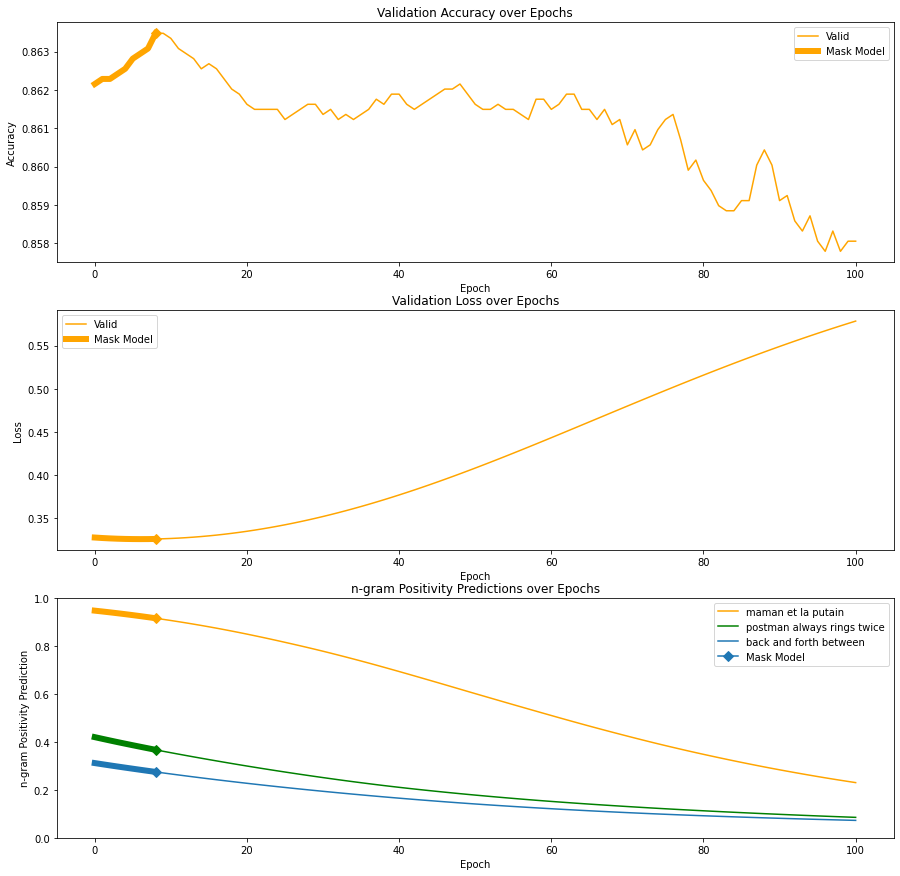

Mask    Epoch: 101 | Time: 1s
                   | Train Loss: 0.708 | Train Acc: 41.23%
                   | Valid Loss: 0.578 | Valid Acc: 85.81%  |  HigestValAcc:86.35 | Diff:0.13


In [54]:
# Load "model_base_final"
model.load_state_dict(torch.load( save_dir + 'model_base_final.pt' ))

examples_mask = []
ngram_test_cases = ['maman et la putain','postman always rings twice','back and forth between']
ngram_predictions = [[],[],[]]
params_mask_embed_feedback = []
params_mask_convl_feedback = []

train_acc_all = []
train_loss_all = []
valid_acc_all = []
valid_loss_all = []

best_acc = 0
best_epoch = 0
_, base_valid_acc = evaluate(model, valid_iterator, criterion)
model.set_train_mode_mask()


optimizer_mask = optim.Adam(
      model.parameters(), lr=0.0000005, weight_decay=0.2)

for epoch in range(NUM_MASK_TRAIN_EPOCHS):
    start_time = time.time()
    
    # Train Model
    train_loss, train_acc = train(model, updated_train_iterator, optimizer_mask, criterion)
    
    # Evaluate on "validation" data
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    epoch_secs = int(end_time - start_time)

    # example_text, example_label = get_example(train_iterator)
    # example_text = ' '.join([str(elem) for elem in example_text])
    example_text = 'normally the first minutes of the film annoy me it includes some reference to the incredible melting man'
    example_predictions = predict_word_scores(model, example_text, window_length=1)
    example_colored_text = token_dict_to_colored_string(example_text, example_predictions)
    examples_mask.append(example_colored_text)  


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    
    if valid_acc > best_acc:
        save_model(save_dir, model, epoch, valid_loss, valid_acc, model_name='model_mask_final')
        best_epoch = epoch
        best_acc = valid_acc
    
    # Save Mask layer parameters for plotting
    mask_param = np.array(model.mask.data.tolist())
    conv_param = np.array(model.maskcnn.data.tolist())
    params_mask_embed_feedback.append(mask_param)
    params_mask_convl_feedback.append(conv_param)
    
    # n-gram prediction with current model
    ngram_score1 = predict_sentiment(model, ngram_test_cases[0])
    ngram_score2 = predict_sentiment(model, ngram_test_cases[1])
    ngram_score3 = predict_sentiment(model, ngram_test_cases[2])
    ngram_score1 = (ngram_score1 - 0.5) * 2  # Change prediction scale 0/1 -> -1/1 s
    ngram_score2 = (ngram_score2 - 0.5) * 2  # Change prediction scale 0/1 -> -1/1 s
    ngram_score3 = (ngram_score3 - 0.5) * 2  # Change prediction scale 0/1 -> -1/1 s
    ngram_predictions[0].append(ngram_score1)
    ngram_predictions[1].append(ngram_score2)
    ngram_predictions[2].append(ngram_score3)
    
    # Save scores and visualize training
    # train_acc_all.append(train_acc)
    # train_loss_all.append(train_loss)
    valid_acc_all.append(valid_acc)
    valid_loss_all.append(valid_loss)
    visualize_mask_training(epoch, best_epoch, ngram_test_cases)
    
    print(f'Mask    Epoch: {epoch+1:03} | Time: {epoch_secs}s')
    print(f'                   | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'                   | Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%  |  HigestValAcc:{best_acc*100:.2f} | Diff:{(best_acc-base_valid_acc)*100:.2f}')

save_model(save_dir, model, epoch, valid_loss, valid_acc, model_name='model_mask_full_train')
##########################################################################################################################

In [55]:
!ffmpeg -r 4 -f image2 -s 1920x1080 -i train_mask_%01d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p -y train_mask.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [56]:
# Visualize sentence explanations over epochs
for i in range(len(examples_mask)):
  print(f'Epoch {i:<3}: {examples_mask[i]}')

Epoch 0  :  normally  the  first  minutes  of  the  film  annoy  me  it  includes  some  reference  to  the  incredible  melting  man 
Epoch 1  :  normally  the  first  minutes  of  the  film  annoy  me  it  includes  some  reference  to  the  incredible  melting  man 
Epoch 2  :  normally  the  first  minutes  of  the  film  annoy  me  it  includes  some  reference  to  the  incredible  melting  man 
Epoch 3  :  normally  the  first  minutes  of  the  film  annoy  me  it  includes  some  reference  to  the  incredible  melting  man 
Epoch 4  :  normally  the  first  minutes  of  the  film  annoy  me  it  includes  some  reference  to  the  incredible  melting  man 
Epoch 5  :  normally  the  first  minutes  of  the  film  annoy  me  it  includes  some  reference  to  the  incredible  melting  man 
Epoch 6  :  normally  the  first  minutes  of  the  film  annoy  me  it  includes  some  reference  to  the  incredible  melting  man 
Epoch 7  :  normally  the  first  minutes  of  the  fil

## Model testing 

Testing `Base` & `Mask` model predictions on texts

In [57]:
# test_text = 'ha ha ha ha'
# test_text = 'nightmare on elm street'
test_text = 'fall in love'



model.load_state_dict(torch.load( save_dir + 'model_base_final.pt' ))
valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
print(f'Sanity check for best "base model"')
print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')


print('-----------------------------------------------------')
print(f'Positivity/Negativity for "{test_text}" by each model')

model.load_state_dict(torch.load( save_dir + 'model_base_final.pt'))
print('Base              =>',(predict_sentiment(model, test_text)-0.5)*2)

model.load_state_dict(torch.load( save_dir + 'model_mask_final.pt' ))
print('Mask (Best Acc)   =>',(predict_sentiment(model, test_text)-0.5)*2)

model.load_state_dict(torch.load( save_dir + 'model_mask_full_train.pt' ))
print('Mask (Full train) =>',(predict_sentiment(model, test_text)-0.5)*2)


Sanity check for best "base model"
Valid Loss: 0.329 | Valid Acc: 86.22%
-----------------------------------------------------
Positivity/Negativity for "fall in love" by each model
Base              => 0.4556947946548462
Mask (Best Acc)   => 0.39592409133911133
Mask (Full train) => 0.0877833366394043


Final Evaluation with **TEST Data**

In [58]:
model.load_state_dict(torch.load( save_dir + 'model_base_final.pt' ))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'(Base) Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

model.load_state_dict(torch.load( save_dir + 'model_mask_final.pt' ))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'(Mask) Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

(Base) Test Loss: 0.330 | Test Acc: 85.93%
(Mask) Test Loss: 0.328 | Test Acc: 85.89%


##  Analysis


### Windowed Analysis

Examples of Explainability generation with different windows lengths (Use a darker background. Colores are picked assuming you are using a dark theme)

In [59]:
review = "At the beginning of the film we watch May and Toots preparing for their not best trip to London for a visit to their grown children. One can see Toots is not in the best of health, but he goes along. When he dies suddenly, May's world, begins to spin out of control.The film directed by Roger Michell, based on a screen play by Hanif Kureshi, is a study of how this mother figure comes to terms with her new status in life and her awakening into a world that she doesn't even know it existed until now.May's life as a suburban wife was probably boring. Obviously her sexual life was next to nothing. We get to know she's had a short extra marital affair, then nothing at all. When May loses her husband she can't go back home, so instead, she stays behind minding her grandson at her daughter's home. It is in this setting that May begins lusting after young and hunky Darren, her daughter's occasional lover.Darren awakes in May a passion she has not ever known. May responds by transforming herself in front of our eyes. May, who at the beginning of the film is dowdy, suddenly starts dressing up, becoming an interesting and attractive woman. She ends up falling heads over heels with this young man that keeps her sated with a passion she never felt before.Having known a couple of cases similar to this story, it came as no surprise to me to watch May's reaction. Her own chance of a normal relationship with Bruce, a widower, ends up frustratingly for May, who realizes how great her sex is with Darren. The younger man, we figure, is only into this affair to satisfy himself and for a possibility of extorting money from May. Finally, the daughter, Helen discovers what Mum has been doing behind her back when she discovers the erotic paintings her mother has made.The film is a triumph for the director. In Anne Reid, Mr. Michell has found an extraordinary actress who brings so much to the role of May. Also amazing is Daniel Craig. He knows how Darren will react to the situation. Anna Wilson Jones as Helen is also vital to the story as she is the one that has to confront the mother about what has been going on behind her back. Oliver Ford Davies plays a small part as Bruce the older man in Helen's class and is quite effective.The film is rewarding for those that will see it with an open mind."

model.load_state_dict(torch.load( save_dir + 'model_base_final.pt'))
model.load_state_dict(torch.load( save_dir + 'model_mask_final.pt'))

tokens_dict_1 = predict_word_scores(model, review, window_length=1)
tokens_dict_2 = predict_word_scores(model, review, window_length=2)
tokens_dict_3 = predict_word_scores(model, review, window_length=3)
tokens_dict_4 = predict_word_scores(model, review, window_length=4)
tokens_dict_5 = predict_word_scores(model, review, window_length=5)
tokens_dict_6 = predict_word_scores(model, review, window_length=6)

print(f'Window length:1 - {token_dict_to_colored_string(review, tokens_dict_1)}')
print(f'Window length:2 - {token_dict_to_colored_string(review, tokens_dict_2)}')
print(f'Window length:3 - {token_dict_to_colored_string(review, tokens_dict_3)}')
print(f'Window length:4 - {token_dict_to_colored_string(review, tokens_dict_4)}')
print(f'Window length:5 - {token_dict_to_colored_string(review, tokens_dict_5)}')
print(f'Window length:6 - {token_dict_to_colored_string(review, tokens_dict_6)}')

Window length:1 -  At  the  beginning  of  the  film  we  watch  May  and  Toots  preparing  for  their  not  best  trip  to  London  for  a  visit  to  their  grown  children.  One  can  see  Toots  is  not  in  the  best  of  health,  but  he  goes  along.  When  he  dies  suddenly,  May's  world,  begins  to  spin  out  of  control.The  film  directed  by  Roger  Michell,  based  on  a  screen  play  by  Hanif  Kureshi,  is  a  study  of  how  this  mother  figure  comes  to  terms  with  her  new  status  in  life  and  her  awakening  into  a  world  that  she  doesn't  even  know  it  existed  until  now.May's  life  as  a  suburban  wife  was  probably  boring.  Obviously  her  sexual  life  was  next  to  nothing.  We  get  to  know  she's  had  a  short  extra  marital  affair,  then  nothing  at  all.  When  May  loses  her  husband  she  can't  go  back  home,  so  instead,  she  stays  behind  minding  her  grandson  at  her  daughter's  home.  It  is  in  this  setting  th

### Kernel Visualization

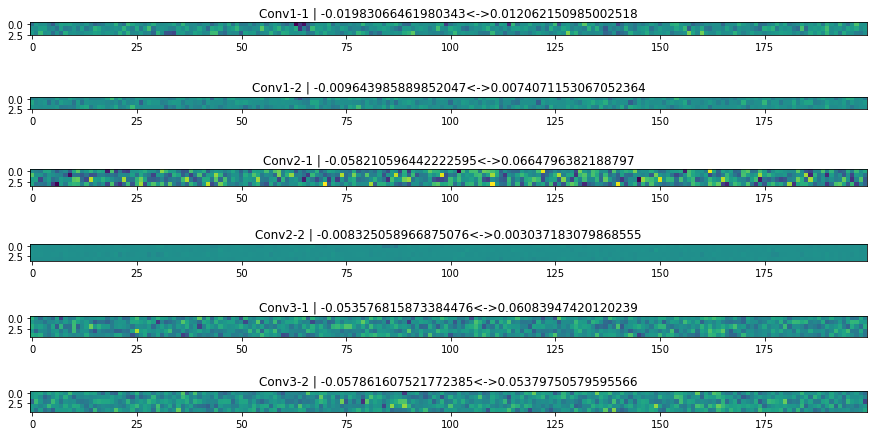

In [60]:
tensor_1_1 = get_conv_tensor(model.convs[0].parameters(),0)
tensor_1_2 = get_conv_tensor(model.convs[0].parameters(),1)
tensor_2_1 = get_conv_tensor(model.convs[1].parameters(),0)
tensor_2_2 = get_conv_tensor(model.convs[1].parameters(),1)
tensor_3_1 = get_conv_tensor(model.convs[2].parameters(),0)
tensor_3_2 = get_conv_tensor(model.convs[2].parameters(),1)

scaled_1_1 = normalize_array_to_pixel_range(tensor_1_1)
scaled_1_2 = normalize_array_to_pixel_range(tensor_1_2)
scaled_2_1 = normalize_array_to_pixel_range(tensor_2_1)
scaled_2_2 = normalize_array_to_pixel_range(tensor_2_2)
scaled_3_1 = normalize_array_to_pixel_range(tensor_3_1)
scaled_3_2 = normalize_array_to_pixel_range(tensor_3_2)


fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(611)
ax.set_title(f'Conv1-1 | {np.min(tensor_1_1)}<->{np.max(tensor_1_1)}')
plt.imshow(tensor_1_1.reshape(3,GloVe_Embedding_Dim), vmin=-0.02, vmax=0.02)
ax.set_aspect('equal')

ax = fig.add_subplot(612)
ax.set_title(f'Conv1-2 | {np.min(tensor_1_2)}<->{np.max(tensor_1_2)}')
plt.imshow(tensor_1_2.reshape(3,GloVe_Embedding_Dim), vmin=-0.02, vmax=0.02)
ax.set_aspect('equal')

ax = fig.add_subplot(613)
ax.set_title(f'Conv2-1 | {np.min(tensor_2_1)}<->{np.max(tensor_2_1)}')
plt.imshow(tensor_2_1.reshape(4,GloVe_Embedding_Dim), vmin=-0.05, vmax=0.05)
ax.set_aspect('equal')

ax = fig.add_subplot(614)
ax.set_title(f'Conv2-2 | {np.min(tensor_2_2)}<->{np.max(tensor_2_2)}')
plt.imshow(tensor_2_2.reshape(4,GloVe_Embedding_Dim), vmin=-0.05, vmax=0.05)
ax.set_aspect('equal')

ax = fig.add_subplot(615)
ax.set_title(f'Conv3-1 | {np.min(tensor_3_1)}<->{np.max(tensor_3_1)}')
plt.imshow(tensor_3_1.reshape(5,GloVe_Embedding_Dim), vmin=-0.08, vmax=0.08)
ax.set_aspect('equal')

ax = fig.add_subplot(616)
ax.set_title(f'Conv3-2 | {np.min(tensor_3_2)}<->{np.max(tensor_3_2)}')
plt.imshow(tensor_3_2.reshape(5,GloVe_Embedding_Dim), vmin=-0.08, vmax=0.08)
ax.set_aspect('equal')

